# Multiperceptrón con TF - Autos - Predicción
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [24]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Carga del Dataset y selección de atributos numéricos**

In [25]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input, LeakyReLU

nombre_archivo = DATOS_DIR + 'autos.csv'


df= pd.read_csv(nombre_archivo, na_values=['?', '??', 'NA', '', 'null'])


print(df.dtypes)
#-- seleccionar los atributos numéricos --
df = df.select_dtypes(include = np.number)

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object


**Asignar atributos sin valor o con valor nulo**

In [26]:
# muestra cantidad de valores faltantes o nulos por atributo/característica
print(df.isnull().sum())


values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

symboling             0
normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64


**Normalización de valores de atributos y valores a predecir**

In [27]:
# Imprime matriz de correclacion
#corr = df.corr()
#plt.figure()
#sns.heatmap(corr, square=True,  annot=True, linewidths=.5)

datos = np.array(df)
normalizarEntrada = 1

attPred = [12,14] #12 mpg-highway y 14 precio  #-- nro de atributos a predecir
T = datos[:, attPred]
X = np.delete(datos, attPred, 1) # elimina columnas de atributos a predecir

if normalizarEntrada:
    data_scaler, target_scaler = StandardScaler(), StandardScaler()
    X = data_scaler.fit_transform(X)
    T = target_scaler.fit_transform(T)

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(X, T, test_size = 0.2,  shuffle = True)

**Construccion del modelo**

In [ ]:
6# cantidad de pasadas de los datos
EPOCAS = 1000
# cantidad de datos a procesar para actualizar pesos
TAM_LOTE = 64

ENTRADAS = X.shape[1]
SALIDAS = len(attPred)

ACTIVACION = LeakyReLU()
#ACTIVACION = 'ReLU'
#ACTIVACION = 'tanh'
#ACTIVACION = 'sigmoid'

#OPTIMIZADOR = 'sgd'
OPTIMIZADOR = 'rmsprop'
#OPTIMIZADOR = 'adam'
PACIENCIA = 15

model = Sequential()
model.add(Input(shape=(ENTRADAS,)))
model.add(Dense(6, activation=ACTIVACION))
model.add(Dense(3, activation= ACTIVACION))
model.add(Dense(SALIDAS))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
model.compile(optimizer=OPTIMIZADOR, loss='mae', metrics = ['mae', 'mse'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 6)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119 (476.00 B)

 Trainable params: 119 (476.00 B)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento del modelo con parada temprana**

In [29]:
# El parámetro patience indica la cantidad de epocas que deben transcurrir
# sin mejoras en el entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA)

# Entrena el modelo y guarda la historia del progreso
history = model.fit(x = x_train, y = y_train, batch_size = TAM_LOTE, epochs = EPOCAS,
              validation_data = (x_val, y_val), callbacks=[early_stop])

print('\n'+'-'*80)
print('Epocas utilizadas: %d' % len(history.epoch))

# %% Evalua e informa resultado de entrenamiento, validación y testeo
# evalua el modelo con los datos de entreanmiento
pred = model.evaluate(x_train, y_train, verbose=0)
print('\nEfectividad del modelo con datos de entrenamiento para:' )
print(" - Accuracy: %6.2f%%" % (pred[1]*100))
print(" - Pérdida : %9.5f" % (pred[0]))

# evalua el modelo con los datos de validacion
pred = model.evaluate(x_val, y_val, verbose=0)
print('\nEfectividad del modelo con datos de validacion para:' )
print(" - Accuracy: %6.2f%%" % (pred[1]*100))
print(" - Pérdida : %9.5f" % (pred[0]))


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 1.3842 - mae: 1.3842 - mse: 3.0369 - val_loss: 1.2454 - val_mae: 1.2454 - val_mse: 2.4094
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2827 - mae: 1.2827 - mse: 2.7141 - val_loss: 1.1983 - val_mae: 1.1983 - val_mse: 2.2418
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 1.2315 - mae: 1.2315 - mse: 2.5186 - val_loss: 1.1608 - val_mae: 1.1608 - val_mse: 2.1192
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.2045 - mae: 1.2045 - mse: 2.3529 - val_loss: 1.1302 - val_mae: 1.1302 - val_mse: 2.0159
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1367 - mae: 1.1367 - mse: 2.1325 - val_loss: 1.1060 - val_mae: 1.1060 - val_mse: 1.9293
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1211 - mae: 1.1211 - mse: 2.1005 - val_loss: 1.0847 - val_mae: 1.0847 - val_mse: 1.8533
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0939 - mae: 1.0939 - mse: 1.9608 - val_loss

**Gráficos con evolución de curvas de error y accuracy**

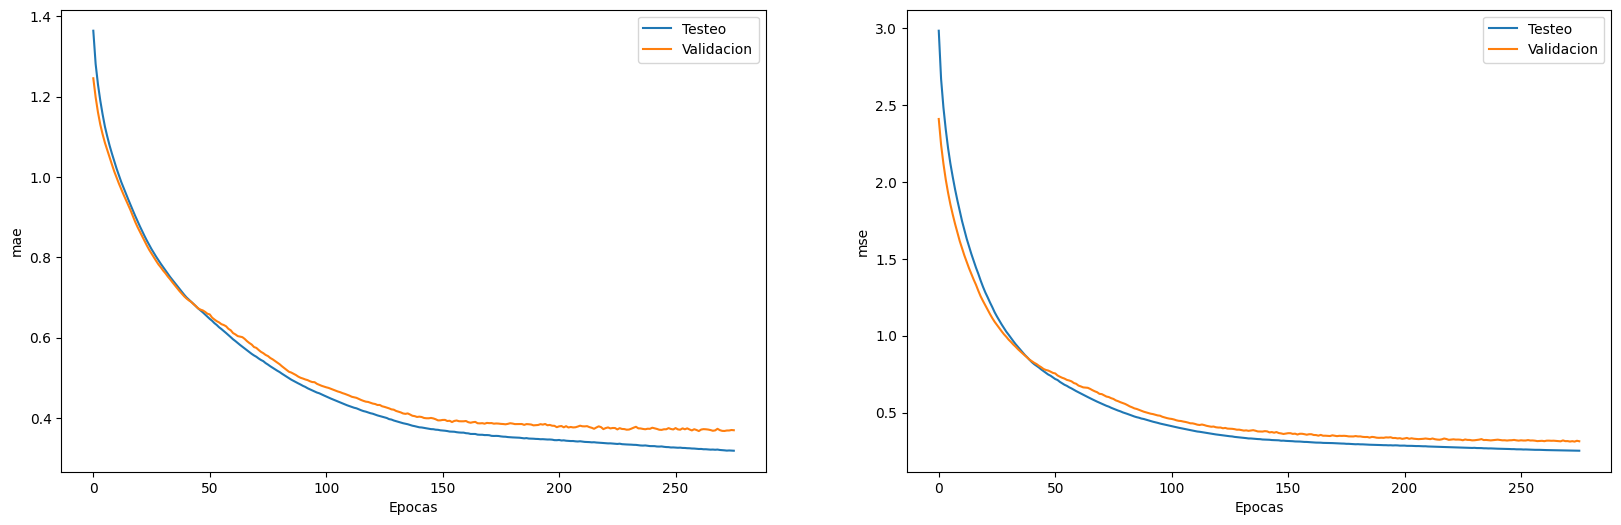

In [30]:
hist = history.history

def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()

fig, axs = plt.subplots(1,2, figsize=(20,6))

dibujar_curva(axs[0], 'mae', history.epoch, hist)
dibujar_curva(axs[1], 'mse', history.epoch, hist)

**Retroalimentación visual de las predicciones sobre los datos de validación**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[Text(0.5, 0, 'Ejemplo'), Text(0, 0.5, 'Precio del Vehículo')]

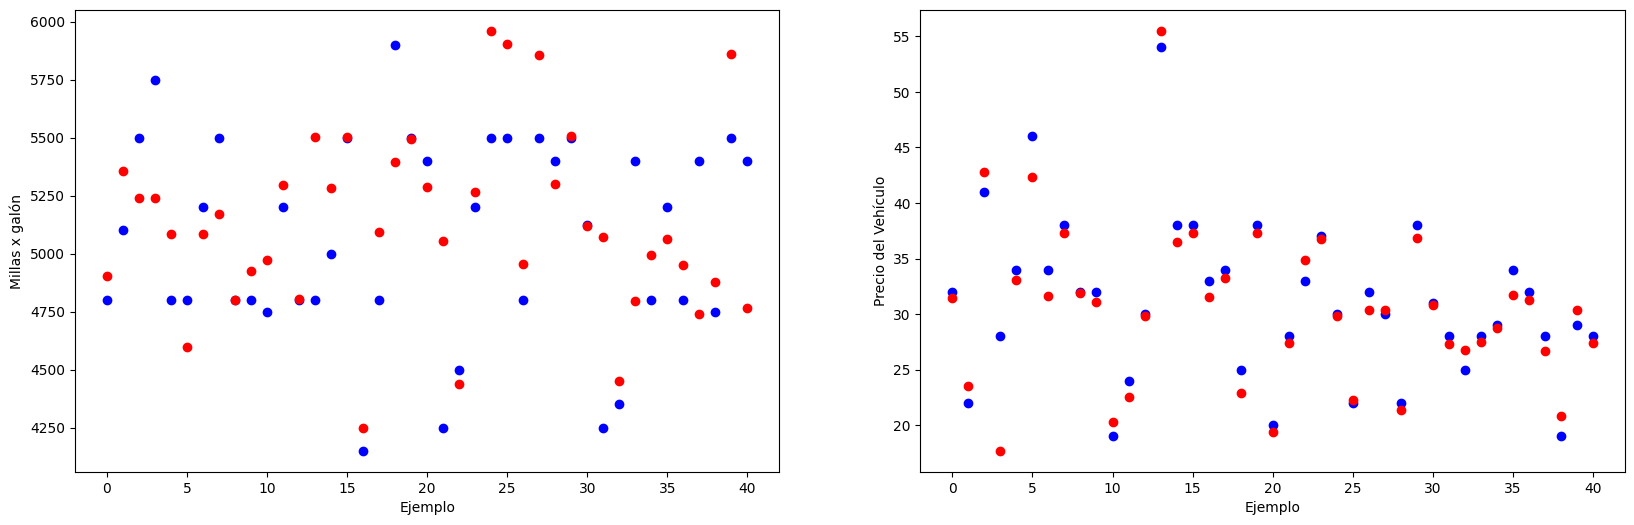

In [ ]:

y_val_no_norm = target_scaler.inverse_transform(y_val)
y_pred_no_norm = target_scaler.inverse_transform(y_pred)

fig, axs = plt.subplots(1,2, figsize=(20,6))

# lista con nro de iteracion
sample = list(range(len(y_val_no_norm)))

axs[0].plot(sample, y_val_no_norm[:,0],  "o", color='blue')
axs[0].plot(sample, y_pred_no_norm[:,0], "o", color='red')
axs[0].set(xlabel='Ejemplo', ylabel='Millas x galón')

axs[1].plot(sample, y_val_no_norm[:,1],  "o", color='blue')
axs[1].plot(sample, y_pred_no_norm[:,1], "o", color='red')
axs[1].set(xlabel='Ejemplo', ylabel='Precio del Vehículo')